# Libs

In [148]:
import os
import re
import sys
import glob
import time
import datetime
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("d:\softwares\python36\lib\site-packages")
from easyeda import eda
from geohash import encode
from geopy.distance import great_circle

from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, LeakyReLU, Input
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import KLD,categorical_crossentropy
from tensorflow.keras.utils import normalize

# Load Data

In [2]:
filedir = glob.glob(pathname='../Data/*.csv')
filedir

['../Data\\area_passenger_index.csv',
 '../Data\\area_passenger_info.csv',
 '../Data\\grid_strength.csv',
 '../Data\\migration_index.csv',
 '../Data\\shortstay_20200117_20200131.csv',
 '../Data\\shortstay_20200201_20200215.csv']

# Feature Engineering

## area info

In [3]:
# load data
area_passenger_info = pd.read_csv(filedir[1], header=None)
area_passenger_info.columns = ['areaIdx', 'areaName', 'areaType', 'centerLon', 'centerLat',
                               'gridLon', 'gridLat', 'coverage']
area_passenger_info.info()

# area type
# 交通设施：0-2，旅游景点：3，教育培训：4，购物：5，医疗：6，运动健身：7
areaTypes = area_passenger_info['areaType'].unique()
normalTypes = {'旅游景点':3,'教育培训':4,'购物':5,'医疗':6,'运动健身':7}
type_to_idx = {}
idx = 0
for item in areaTypes:
    preType = re.match("(.*);(.*)",item)[1]
    if  preType == '交通设施':
        type_to_idx[item] = idx
        idx += 1
    elif preType in normalTypes.keys():
        type_to_idx[item] = normalTypes[preType]
    else:
        print("this type does not exist.")

area_passenger_info['areaType'] = area_passenger_info['areaType'].replace(type_to_idx)
area_passenger_info['coverage'] = area_passenger_info['coverage'] / 4e+4

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 8 columns):
areaIdx      997 non-null int64
areaName     997 non-null object
areaType     997 non-null object
centerLon    997 non-null float64
centerLat    997 non-null float64
gridLon      997 non-null float64
gridLat      997 non-null float64
coverage     997 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 62.4+ KB


## index-stats embedding

In [4]:
area_passenger_ind = pd.read_csv(filedir[0],header = None)
area_passenger_ind.columns = ['areaIdx','datetime','Density']
area_passenger_ind['datetime'] = pd.to_datetime(area_passenger_ind['datetime'],format="%Y%m%d%H")
area_passenger_ind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717840 entries, 0 to 717839
Data columns (total 3 columns):
areaIdx     717840 non-null int64
datetime    717840 non-null datetime64[ns]
Density     717840 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 16.4 MB


In [147]:
embed_data.head()

,areaIdx,datetime,Density,ToD,DoW,areaName,areaType,centerLon,centerLat,gridLon,gridLat,coverage
0,1,2020-01-17 00:00:00,1.8,0,4,北坞公园,3,116.256586,39.986913,116.256713,39.987525,9.89814
1,1,2020-01-17 01:00:00,1.5,1,4,北坞公园,3,116.256586,39.986913,116.256713,39.987525,9.89814
2,1,2020-01-17 02:00:00,1.3,2,4,北坞公园,3,116.256586,39.986913,116.256713,39.987525,9.89814
3,1,2020-01-17 03:00:00,1.3,3,4,北坞公园,3,116.256586,39.986913,116.256713,39.987525,9.89814
4,1,2020-01-17 04:00:00,1.7,4,4,北坞公园,3,116.256586,39.986913,116.256713,39.987525,9.89814


In [144]:
area_passenger_ind['ToD'] = area_passenger_ind['datetime'].map(lambda x: x.hour)
area_passenger_ind['DoW'] = area_passenger_ind['datetime'].map(lambda x: x.weekday())
embed_data = pd.merge(area_passenger_ind,area_passenger_info,on='areaIdx')
embed_label = area_passenger_ind.pivot_table(index='areaIdx',
                                             columns='ToD',
                                             values='Density',
                                             aggfunc=['mean', 'std', 'median', np.ptp])

In [6]:
def get_embedding(embedding_dim, batch_size, epochs):
    # build model
    x = Input(shape=(1,))
    o = Embedding(input_dim=997, output_dim=embedding_dim,
                  embeddings_initializer=he_normal(), name='embedding')(x)
    h = Dense(24 * 4, use_bias=False,
              kernel_initializer=he_normal(), activation='relu')(o)
    model = Model(inputs=x, outputs=h)
    model.compile(loss='mse', optimizer=Adam(3e-4))
    
    # train embedding weights
    hist = model.fit(np.arange(0, 997).reshape(-1, 1), normalize(embed_label.values),
                 batch_size=batch_size, epochs=epochs, shuffle=True, verbose=0)
    
    # output embedding vector
    areaEmbedding = model.get_weights()[0]
    
    return areaEmbedding, hist

In [57]:
embedding_dim = 50
areaEmbedding, trainingLog = get_embedding(embedding_dim=embedding_dim,
                                           batch_size=16,epochs=500)

In [97]:
svd_dim = 30
svd = TruncatedSVD(n_components=svd_dim, n_iter=20, random_state=2020)
svd = svd.fit(areaEmbedding.T)
areaEmbedding = svd.components_.T

## Historic index (same area)

In [8]:
def get_hitoric_index(area_passenger_ind, window_size, num_samples, num_areas, num_days):
    
    # init
    historicIndex = np.zeros((num_samples, window_size))
    sample_idx = 0
    sp = time.time()
    
    # main loop
    for area_idx in range(1, num_areas + 1):
        if area_idx % 200 == 0:
            print("[Area-{:d}] started, duration: {:.1f} sec.".format(area_idx, time.time() - sp))
        area_df = area_passenger_ind[area_passenger_ind.areaIdx == area_idx]
        for i in range(24 * num_days - window_size):
            historicIndex[sample_idx] = area_df['Density'].values[i:i + window_size]
            sample_idx += 1
    
    return historicIndex

In [9]:
# params
window_size = 8
num_areas = 997
num_days = 30
num_samples = (24 * num_days - window_size)  * num_areas

# get historic index
historicIndex = get_hitoric_index(area_passenger_ind,
                                  window_size=window_size,
                                  num_samples=num_samples,
                                  num_areas=num_areas,
                                  num_days=num_days)

[Area-200] started, duration: 0.7 sec.
[Area-400] started, duration: 1.4 sec.
[Area-600] started, duration: 2.0 sec.
[Area-800] started, duration: 2.7 sec.


In [130]:
histMean = historicIndex.mean(axis=1)
histStd = historicIndex.std(axis=1)
histMedian = np.median(historicIndex, axis=1)
histPtp = np.ptp(historicIndex, axis=1)
histDiff = historicIndex[:,1:] - historicIndex[:,:(window_size - 1)]

In [131]:
historicIndexDf = pd.DataFrame()

for col in range(window_size):
    historicIndexDf['historic_' + str(col)] = historicIndex[:,col]

for col in range(window_size - 1):
    historicIndexDf['historic_diff_' + str(col)] = histDiff[:,col]

historicIndexDf['histMean'] = histMean
historicIndexDf['histStd'] = histStd
historicIndexDf['histMedian'] = histMedian
historicIndexDf['histPtp'] = histPtp

## Concat

In [99]:
areaEmbeddingDf = pd.DataFrame(np.arange(1,998),columns=['areaIdx'])
for col in range(svd_dim):
    areaEmbeddingDf["embedding_" + str(col)] = areaEmbedding[:,col]

In [100]:
areaAttr = pd.merge(area_passenger_info, areaEmbeddingDf, on='areaIdx')
areaAttr.drop('areaName', axis=1, inplace=True)

In [101]:
dfs = [area_passenger_ind, areaAttr]
AreaDensity = reduce(lambda a,b:pd.merge(a,b,on='areaIdx'),dfs)
AreaDensity.drop("datetime",axis=1,inplace=True)

# Build Dataset

In [132]:
# init
X_attr = np.zeros((num_samples,AreaDensity.shape[1]))
sample_idx = 0
sp = time.time()

# main loop
for area_idx in range(1, num_areas + 1):
    if area_idx % 200 == 0:
        print("[Area-{:d}] started, duration: {:.1f} sec.".format(area_idx, time.time() - sp))
    area_df = AreaDensity[AreaDensity.areaIdx == area_idx]
    for i in range(window_size, 24 * num_days):
        X_attr[sample_idx] = area_df.values[i,:]
        sample_idx += 1

[Area-200] started, duration: 11.6 sec.
[Area-400] started, duration: 23.3 sec.
[Area-600] started, duration: 35.2 sec.
[Area-800] started, duration: 47.0 sec.


In [139]:
X = pd.concat((pd.DataFrame(X_attr, columns=AreaDensity.columns),
               historicIndexDf), axis=1)
Y_data = X['Density']
X_data = X.drop(['Density'], axis=1)

In [140]:
svd_feat_dim = 5
svd = TruncatedSVD(n_components=svd_feat_dim,n_iter=10,random_state=1324)
svd = svd.fit(normalize(X_data.T))
svdFeature = svd.components_.T

for col in range(svd_feat_dim):
    X_data['svd_' + str(col)] = svdFeature[:,col]

# LightGBM

In [17]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [113]:
params = {
    "objective":"regression",
    "num_rounds":10000,
    "learning_rate":0.01,
    "max_depth":9,
    "num_leaves":100,
    "feature_fraction":0.8,
    "verbose":2
}

In [46]:
def score(y_pred, y_test):
    rmse = np.sqrt(np.mean(np.square(y_pred - y_test)))
    return 1/(1 + rmse)

In [141]:
kf = KFold(n_splits=5,shuffle=True)
idx = 0
for train_idx, test_idx in kf.split(X_data):
    # dataset split
    X_train, y_train = X_data.iloc[train_idx], Y_data.iloc[train_idx]
    X_test, y_test = X_data.iloc[test_idx], Y_data.iloc[test_idx]
    
    # train
    train_data = lgb.Dataset(X_train,y_train,categorical_feature=['areaIdx','ToD', 'DoW', 'areaType'])
    test_data = lgb.Dataset(X_test,y_test,reference=train_data)
    
    gbm = lgb.train(params,train_data)
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    print("[CV-{:d}] score: {:.4f}".format(idx, score(y_pred,y_test)))
    idx += 1

[CV-0] score: 0.0720
[CV-1] score: 0.0557
[CV-2] score: 0.0646
[CV-3] score: 0.0670
[CV-4] score: 0.0617


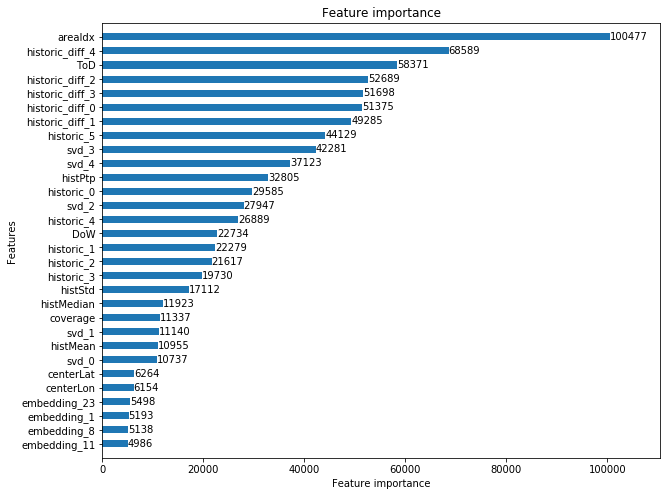

In [142]:
lgb.plot_importance(gbm,max_num_features = 30, height = 0.5,figsize=(10,8),grid = False)

# Test Auto-aggressive prediction

In [149]:
submit_table = pd.read_csv('../Data/submit_example/test_submit_example.csv', header=None)

In [219]:
X_test = submit_table.copy()
X_test.columns = ['areaIdx','datetime','predIndex']

X_test['datetime'] = pd.to_datetime(X_test['datetime'],format="%Y%m%d%H")
X_test['ToD'] = X_test['datetime'].map(lambda x: x.hour)
X_test['DoW'] = X_test['datetime'].map(lambda x: x.weekday())

dfs = [X_test,area_passenger_info,areaEmbeddingDf]
X_test = reduce(lambda a,b:pd.merge(a,b,on='areaIdx'),dfs)

In [194]:
def get_historic_feature(values, window_size):
    historic_ = values[-window_size:]
    historic_diff_ = np.array(historic_[-window_size + 1:]) - np.array(historic_[-window_size:-1])
    histMean = np.mean(historic_)
    histStd = np.std(historic_)
    histMedian = np.median(historic_)
    histPtp = np.ptp(historic_)
    return historic_ + historic_diff_.tolist() + [histMean,histStd,histMedian,histPtp]

In [224]:
test_input = X_test.drop(["datetime","predIndex","areaName"],axis = 1)
sample_idx = 0
sp = time.time()
for areaIdx in range(1, 1 + num_areas):
    X_test_area = X_test[X_test.areaIdx == areaIdx]
    histValues = area_passenger_ind[area_passenger_ind.areaIdx == areaIdx]['Density'].values.tolist()
    histSvdValues = X_data[X_data.areaIdx == areaIdx][['svd_0','svd_1','svd_2','svd_3','svd_4']].values.tolist()
    for i in range(len(X_test_area)):
        # predict
        histFeat = get_historic_feature(histValues,window_size=window_size)
        test_svd = histSvdValues[-24 * 7]
        test_sample_input = test_input.iloc[i,:].tolist() + histFeat + test_svd
        pred_value = gbm.predict([test_sample_input])[0]
        
        # update submit file
        submit_table.iloc[sample_idx,2] = pred_value
        
        # update aggressive base
        histValues.append(pred_value)
        histSvdValues.append(test_svd)
        sample_idx += 1
        
    print("[Area-{:d}] Finished. Duration: {:.1f} sec.".format(areaIdx,time.time() - sp))

[Area-1] Finished. Duration: 2.4 sec.
[Area-2] Finished. Duration: 4.8 sec.
[Area-3] Finished. Duration: 7.1 sec.
[Area-4] Finished. Duration: 9.5 sec.
[Area-5] Finished. Duration: 11.8 sec.
[Area-6] Finished. Duration: 14.1 sec.
[Area-7] Finished. Duration: 16.5 sec.
[Area-8] Finished. Duration: 18.9 sec.
[Area-9] Finished. Duration: 21.3 sec.
[Area-10] Finished. Duration: 23.6 sec.
[Area-11] Finished. Duration: 26.0 sec.
[Area-12] Finished. Duration: 28.3 sec.
[Area-13] Finished. Duration: 30.7 sec.
[Area-14] Finished. Duration: 33.0 sec.
[Area-15] Finished. Duration: 35.4 sec.
[Area-16] Finished. Duration: 37.8 sec.
[Area-17] Finished. Duration: 40.1 sec.
[Area-18] Finished. Duration: 42.5 sec.
[Area-19] Finished. Duration: 44.8 sec.
[Area-20] Finished. Duration: 47.1 sec.
[Area-21] Finished. Duration: 49.6 sec.
[Area-22] Finished. Duration: 52.0 sec.
[Area-23] Finished. Duration: 54.3 sec.
[Area-24] Finished. Duration: 56.7 sec.
[Area-25] Finished. Duration: 59.1 sec.
[Area-26] Fin

In [227]:
submit_table.to_csv('../Data/submit_files/embedding_window=6_20200311.csv',header=None,index=None)